# Objective:

Comparing DNN and LEAR ensemble models as a benchmark and LSTM model using same sets of Train and Test datas. 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

2023-04-21 22:05:00.623639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import Libraries for reading data
import epftoolbox_1
from epftoolbox_1.data import read_data
from epftoolbox_1.data import DataScaler

In [3]:
# Import Libraries for Model Evaluation
from epftoolbox.evaluation import MAE 
from epftoolbox.evaluation import RMSE 
from epftoolbox.evaluation import MAPE
from epftoolbox.evaluation import sMAPE
from epftoolbox.evaluation import MASE
from epftoolbox.evaluation import rMAE

# LSTM Model for Nord Pool Market

In [4]:
# Load data into dataframe
df_train, df_test = read_data(path='.', dataset='NP', begin_test_date='12/27/2016', end_test_date='12/24/2018')

Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00


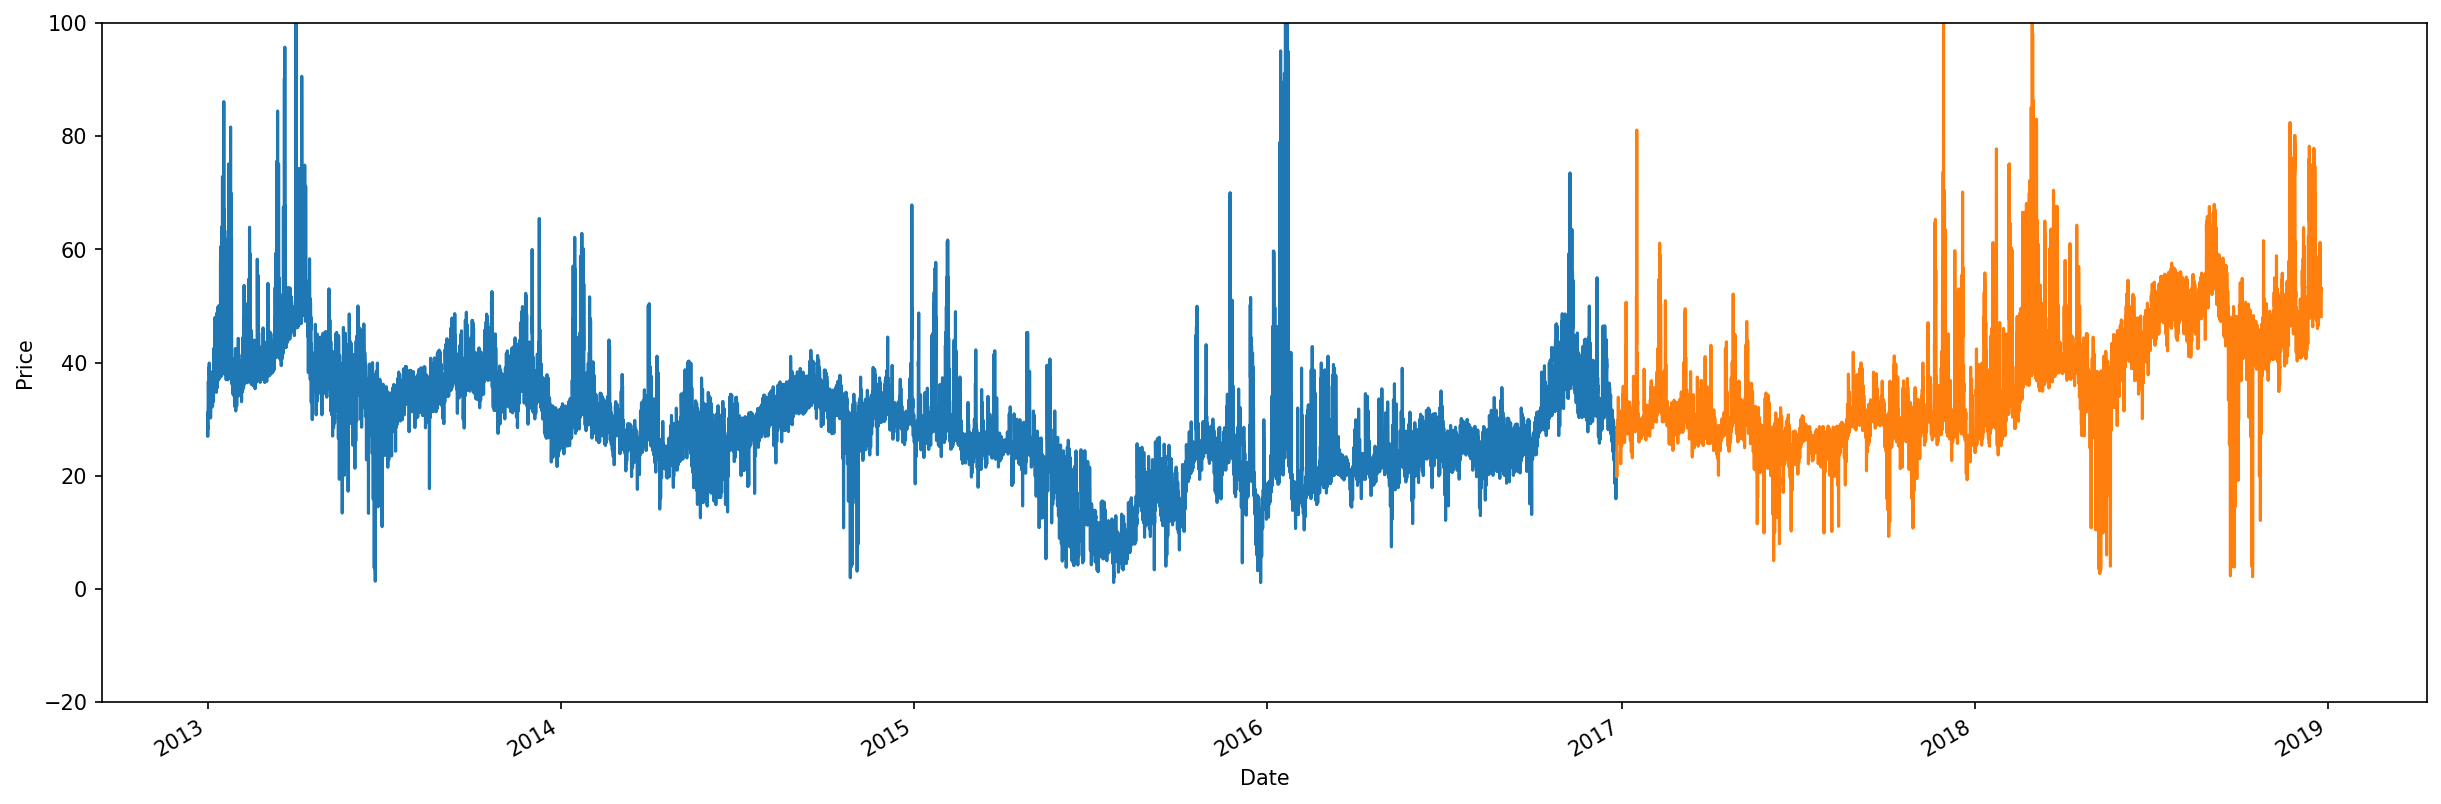

In [5]:
import matplotlib.pyplot as plt

# ploting Train (Blue) and Test (Orange) data

plt.figure(figsize=(20,6) ,dpi=150)

plt.plot(df_train.Price)
plt.plot(df_test.Price)
plt.ylim(-20, 100)
plt.xticks(rotation=30, ha='right')
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig('NP_A.png')

In [6]:
# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]

In [7]:
# Function to create data for LSTM
def create_lstm_data(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [8]:
# Create LSTM model for 24 LookBack

predict = 24
look_back = 24

Xtest = pd.concat([df_train.iloc[-look_back-predict:, [0]],Xtest.loc[:]]).reset_index(drop=False)
Xtest = Xtest.set_index('Date')
Xtest.index = pd.to_datetime(Xtest.index)

#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape)
print('Test Dimension : ', Xtest.shape)

# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

# Create data for LSTM
train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

Train Dimension :  (34944, 1)
Test Dimension :  (17520, 1)


In [9]:
# Create LSTM Model
#Start Time
st_24 = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

#fit the model
model.fit(train_X, train_y, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

#End time 
et_24 = time.time()

2023-04-21 22:05:12.678853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/12
492/492 [==============================] - 19s 34ms/step - loss: 7.4646e-04 - val_loss: 2.3578e-04
Epoch 2/12
492/492 [==============================] - 13s 27ms/step - loss: 3.5870e-04 - val_loss: 1.2561e-04
Epoch 3/12
492/492 [==============================] - 12s 24ms/step - loss: 2.3433e-04 - val_loss: 9.3316e-05
Epoch 4/12
492/492 [==============================] - 13s 26ms/step - loss: 1.4809e-04 - val_loss: 5.1990e-05
Epoch 5/12
492/492 [==============================] - 12s 25ms/step - loss: 1.1010e-04 - val_loss: 4.8881e-05
Epoch 6/12
492/492 [==============================] - 12s 24ms/step - loss: 1.0250e-04 - val_loss: 3.4823e-05
Epoch 7/12
492/492 [==============================] - 12s 24ms/step - loss: 1.0051e-04 - val_loss: 3.0245e-05
Epoch 8/12
492/492 [==============================] - 12s 24ms/step - loss: 9.7551e-05 - val_loss: 3.2238e-05
Epoch 9/12
492/492 [==============================] - 12s 24ms/step - loss: 9.4999e-05 - val_loss: 3.8132e-05
Epoch 10/1

In [10]:
# predicting price for 24 hr time period 
Xtest_data = Xtest_scaled.reshape(1,Xtest_scaled.shape[0],1)
predicted_values_24 = []

for h in range(0,int(len(Xtest)-predict-look_back)):
    input_data = Xtest_data[:,h:h+look_back,:]
    output_data = model.predict(input_data)
    predicted_values_24.append(output_data)
    
#Creating List for output
Output_24 = [elem for twod in predicted_values_24 for elem in twod]
predicted_values_24 = scaler.inverse_transform(Output_24)

#Creating Data for Observed and Predicted Values 
res = pd.DataFrame(Xtest[look_back+predict:], index = Xtest.index[look_back+predict:])
res['Predicted_24'] = predicted_values_24

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


In [11]:
# Create LSTM model for 48 LookBack

predict = 24
look_back = 48

# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]
Xtest = pd.concat([df_train.iloc[-look_back-predict:, [0]],Xtest.loc[:]]).reset_index(drop=False)
Xtest = Xtest.set_index('Date')
Xtest.index = pd.to_datetime(Xtest.index)

#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape)
print('Test Dimension : ', Xtest.shape)

# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

# Create data for LSTM
train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

Train Dimension :  (34944, 1)
Test Dimension :  (17544, 1)


In [12]:
# Create LSTM Model
#Start Time
st_48 = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

#fit the model
model.fit(train_X, train_y, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

#End time 
et_48 = time.time()

Epoch 1/12
491/491 [==============================] - 24s 45ms/step - loss: 8.5106e-04 - val_loss: 2.5342e-04
Epoch 2/12
491/491 [==============================] - 22s 44ms/step - loss: 3.8691e-04 - val_loss: 1.4403e-04
Epoch 3/12
491/491 [==============================] - 22s 44ms/step - loss: 2.8284e-04 - val_loss: 1.9369e-04
Epoch 4/12
491/491 [==============================] - 22s 44ms/step - loss: 1.6933e-04 - val_loss: 4.1113e-05
Epoch 5/12
491/491 [==============================] - 22s 44ms/step - loss: 1.0829e-04 - val_loss: 4.6356e-05
Epoch 6/12
491/491 [==============================] - 22s 45ms/step - loss: 1.0338e-04 - val_loss: 3.6949e-05
Epoch 7/12
491/491 [==============================] - 24s 49ms/step - loss: 9.4753e-05 - val_loss: 3.0318e-05
Epoch 8/12
491/491 [==============================] - 23s 46ms/step - loss: 9.5223e-05 - val_loss: 3.8549e-05
Epoch 9/12
491/491 [==============================] - 22s 45ms/step - loss: 9.2293e-05 - val_loss: 3.6202e-05
Epoch 10/1

In [13]:
# predicting price for 24 hr time period 
Xtest_data = Xtest_scaled.reshape(1,Xtest_scaled.shape[0],1)
predicted_values_48 = []

for h in range(0,int(len(Xtest)-predict-look_back)):
    input_data = Xtest_data[:,h:h+look_back,:]
    output_data = model.predict(input_data)
    predicted_values_48.append(output_data)
    
#Creating List for output
Output_48 = [elem for twod in predicted_values_48 for elem in twod]
predicted_values_48 = scaler.inverse_transform(Output_48)

#Creating Data for Observed and Predicted Values 
res['Predicted_48'] = predicted_values_48

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


In [14]:
# Create LSTM model for 96 LookBack

predict = 24
look_back = 96

# Creating Train and Test Data
Xtrain = df_train.iloc[:, [0]]
Xtest = df_test.iloc[:, [0]]
Xtest = pd.concat([df_train.iloc[-look_back-predict:, [0]],Xtest.loc[:]]).reset_index(drop=False)
Xtest = Xtest.set_index('Date')
Xtest.index = pd.to_datetime(Xtest.index)

#Dimensions of Train and Test Data
print('Train Dimension : ', Xtrain.shape)
print('Test Dimension : ', Xtest.shape)

# Scalar Transformation of both train and test data
scaler = DataScaler('Norm')
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.fit_transform(Xtest.loc[:])

# Create data for LSTM
train_X, train_y = create_lstm_data(Xtrain_scaled, look_back)
# Reshape data for LSTM
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))

Train Dimension :  (34944, 1)
Test Dimension :  (17592, 1)


In [15]:
# Create LSTM Model
#Start Time
st_96 = time.time()

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

#fit the model
model.fit(train_X, train_y, epochs=12, batch_size=64, validation_split=0.1, verbose=1)

#End time 
et_96 = time.time()

Epoch 1/12
491/491 [==============================] - 44s 85ms/step - loss: 7.4863e-04 - val_loss: 2.0872e-04
Epoch 2/12
491/491 [==============================] - 41s 83ms/step - loss: 3.6789e-04 - val_loss: 1.5358e-04
Epoch 3/12
491/491 [==============================] - 41s 84ms/step - loss: 2.6477e-04 - val_loss: 7.7360e-05
Epoch 4/12
491/491 [==============================] - 41s 84ms/step - loss: 1.5927e-04 - val_loss: 2.6559e-04
Epoch 5/12
491/491 [==============================] - 41s 84ms/step - loss: 1.1687e-04 - val_loss: 3.8009e-05
Epoch 6/12
491/491 [==============================] - 42s 87ms/step - loss: 1.0307e-04 - val_loss: 3.1121e-05
Epoch 7/12
491/491 [==============================] - 49s 99ms/step - loss: 9.6510e-05 - val_loss: 2.9727e-05
Epoch 8/12
491/491 [==============================] - 41s 84ms/step - loss: 9.2660e-05 - val_loss: 3.9600e-05
Epoch 9/12
491/491 [==============================] - 41s 84ms/step - loss: 9.3162e-05 - val_loss: 7.6305e-05
Epoch 10/1

In [16]:
# predicting price for 24 hr time period 
Xtest_data = Xtest_scaled.reshape(1,Xtest_scaled.shape[0],1)
predicted_values_96 = []

for h in range(0,int(len(Xtest)-predict-look_back)):
    input_data = Xtest_data[:,h:h+look_back,:]
    output_data = model.predict(input_data)
    predicted_values_96.append(output_data)
    
#Creating List for output
Output_96 = [elem for twod in predicted_values_96 for elem in twod]
predicted_values_96 = scaler.inverse_transform(Output_96)

#Creating Data for Observed and Predicted Values 
res['Predicted_96'] = predicted_values_96

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


In [17]:
res.head(10)

,Price,Predicted_24,Predicted_48,Predicted_96
Date,,,,
2016-12-27 00:00:00,24.08,24.808052,24.904461,24.899705
2016-12-27 01:00:00,22.52,24.922192,25.138650,25.346914
2016-12-27 02:00:00,20.13,21.593275,21.897782,21.707655
2016-12-27 03:00:00,19.86,18.279168,18.642421,18.565318
2016-12-27 04:00:00,20.09,15.645024,16.083027,16.153793
2016-12-27 05:00:00,23.93,17.199766,17.618439,18.202471
2016-12-27 06:00:00,26.23,17.472143,17.891372,18.407567
2016-12-27 07:00:00,27.76,24.944114,25.234409,26.712059
2016-12-27 08:00:00,28.06,25.905897,26.075551,27.019573


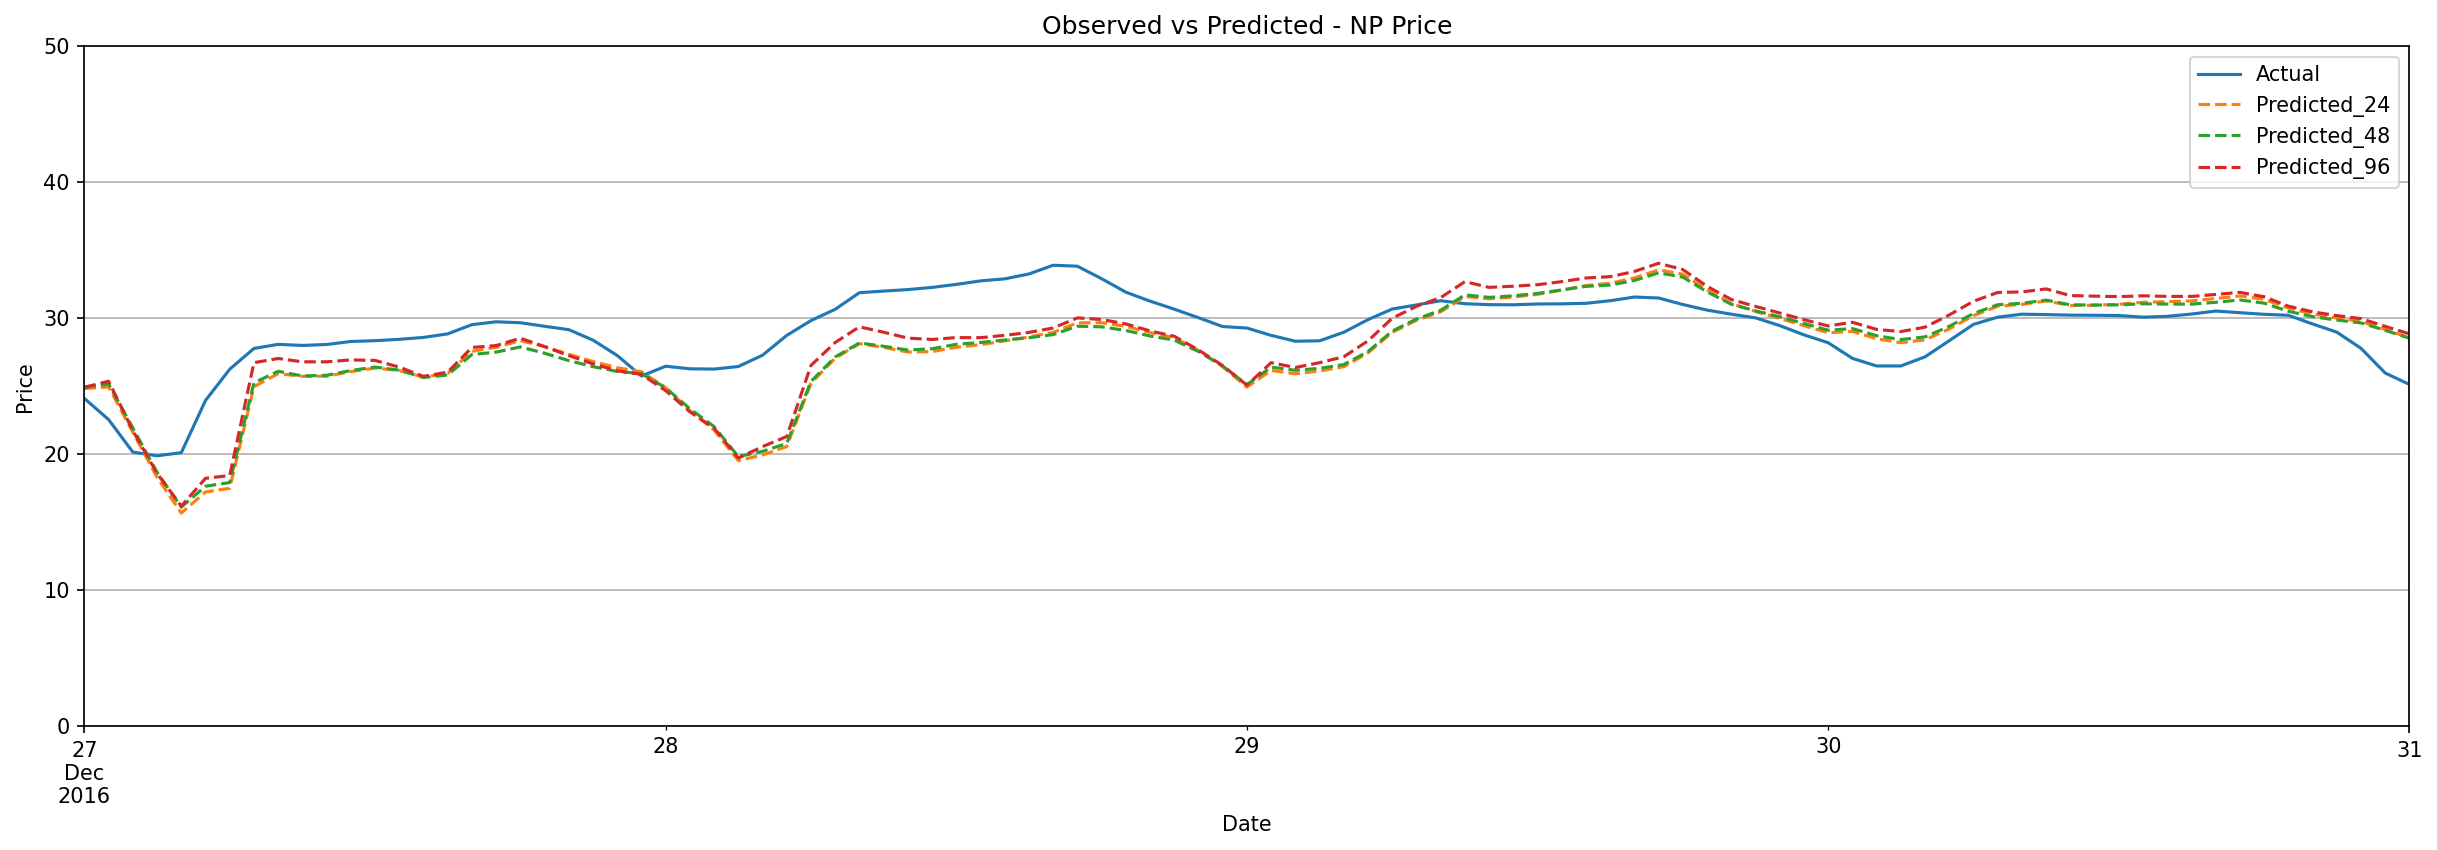

In [18]:
# ploting Observed and predicted values for 4 days 
plt.figure(figsize=(20,6) ,dpi=150)

ax1 = res.Price.plot(grid=True, label='Actual')
ax2 = res.Predicted_24.plot(grid=True, label='Predicted_24',linestyle='--')
ax3 = res.Predicted_48.plot(grid=True, label='Predicted_48',linestyle='--')
ax4 = res.Predicted_96.plot(grid=True, label='Predicted_96',linestyle='--')


ax1.set_ylim(0, 50)
ax2.set_ylim(0, 50)
ax3.set_ylim(0, 50)
ax4.set_ylim(0, 50)

plt.title('Observed vs Predicted - NP Price')
plt.xlim([datetime.date(2016,12,27), datetime.date(2016, 12, 31)])
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc ="best")
plt.savefig('NP_P.png')
plt.show()

In [19]:
# Model Evaluation for LSTM for 24
MAE_l_24 = MAE(p_pred=res.Predicted_24, p_real=res.Price)
RMSE_l_24 = RMSE(p_pred=res.Predicted_24, p_real=res.Price)
MAPE_l_24 = MAPE(p_pred=res.Predicted_24, p_real=res.Price) * 100
sMAPE_l_24 = sMAPE(p_pred=res.Predicted_24, p_real=res.Price) * 100
MASE_l_24 = MASE(p_pred=res.Predicted_24, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l_24 = rMAE(p_pred=res.Predicted_24, p_real=res.Price)

In [20]:
# Model Evaluation for LSTM for 48
MAE_l_48 = MAE(p_pred=res.Predicted_48, p_real=res.Price)
RMSE_l_48 = RMSE(p_pred=res.Predicted_48, p_real=res.Price)
MAPE_l_48 = MAPE(p_pred=res.Predicted_48, p_real=res.Price) * 100
sMAPE_l_48 = sMAPE(p_pred=res.Predicted_48, p_real=res.Price) * 100
MASE_l_48 = MASE(p_pred=res.Predicted_48, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l_48 = rMAE(p_pred=res.Predicted_48, p_real=res.Price)

In [21]:
# Model Evaluation for LSTM for 96
MAE_l_96 = MAE(p_pred=res.Predicted_96, p_real=res.Price)
RMSE_l_96 = RMSE(p_pred=res.Predicted_96, p_real=res.Price)
MAPE_l_96 = MAPE(p_pred=res.Predicted_96, p_real=res.Price) * 100
sMAPE_l_96 = sMAPE(p_pred=res.Predicted_96, p_real=res.Price) * 100
MASE_l_96 = MASE(p_pred=res.Predicted_96, p_real=res.Price, p_real_in=res.Price, m='W')
rMAE_l_96 = rMAE(p_pred=res.Predicted_96, p_real=res.Price)

# DNN ensemble Model for Nord Pool Market

In [22]:
# Read the predicted datas using benchmark models in the paper 
forecast = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/' +
                     'forecasts/Forecasts_NP_DNN_LEAR_ensembles.csv', index_col=0)
# Transforming indices to datetime format
forecast.index = pd.to_datetime(forecast.index)
# Reading data from the NP market
df_train, df_test = read_data(path='.', dataset='NP', begin_test_date=forecast.index[0],
                        end_test_date=forecast.index[-1])
#predicted price
fc_DNN_ensemble = forecast.loc[:, ['DNN Ensemble']]
fc_LEAR_ensemble = forecast.loc[:, ['LEAR Ensemble']]
#Real price
real_price = df_test.loc[:, ['Price']]

Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00


In [23]:
#Model Evaluation for DNN in Paper
MAE_p = MAE(p_pred=fc_DNN_ensemble, p_real=real_price)
RMSE_p = RMSE(p_pred=fc_DNN_ensemble, p_real=real_price)
MAPE_p = MAPE(p_pred=fc_DNN_ensemble, p_real=real_price) * 100
sMAPE_p = sMAPE(p_pred=fc_DNN_ensemble, p_real=real_price) * 100
MASE_p = MASE(p_pred=fc_DNN_ensemble, p_real=real_price, p_real_in=real_price, m='W')
rMAE_p = rMAE(p_pred=fc_DNN_ensemble, p_real=real_price)

In [24]:
#Model Evaluation for LEAR in Paper
MAE_le = MAE(p_pred=fc_LEAR_ensemble, p_real=real_price)
RMSE_le = RMSE(p_pred=fc_LEAR_ensemble, p_real=real_price)
MAPE_le = MAPE(p_pred=fc_LEAR_ensemble, p_real=real_price) * 100
sMAPE_le = sMAPE(p_pred=fc_LEAR_ensemble, p_real=real_price) * 100
MASE_le = MASE(p_pred=fc_LEAR_ensemble, p_real=real_price, p_real_in=real_price, m='W')
rMAE_le = rMAE(p_pred=fc_LEAR_ensemble, p_real=real_price)

## Summary table for Model evaluation

In [25]:
#Summary table for Model evaluation
from tabulate import tabulate
print(tabulate([['Mean Absolute Error (MAE):', MAE_p ,MAE_le,MAE_l_24,MAE_l_48,MAE_l_96], 
                ['Root Mean Square Error (RMSE):',RMSE_p,RMSE_le,RMSE_l_24,RMSE_l_48,RMSE_l_96],
                ['Mean Absolute Percentage Error (MAPE):',MAPE_p,MAPE_le,MAPE_l_24,MAPE_l_48,MAPE_l_96],
               ['symmetric Mean Absolute Percentage Error (sMAPE):',sMAPE_p,sMAPE_le,sMAPE_l_24,sMAPE_l_48,sMAPE_l_96],
                ['Mean Absolute Scaled Error (MASE):',MASE_p,MASE_le,MASE_l_24,MASE_l_48,MASE_l_96],
                ['relative Mean Absolute Error(rMAE):',rMAE_p,rMAE_le,rMAE_l_24,rMAE_l_48,rMAE_l_96]],headers=['Evaluation for Nord Pool Market','DNN_ensem','LEAR_ensem','LSTM-24','LSTM-48','LSTM-96']))

Evaluation for Nord Pool Market                      DNN_ensem    LEAR_ensem    LSTM-24    LSTM-48    LSTM-96
-------------------------------------------------  -----------  ------------  ---------  ---------  ---------
Mean Absolute Error (MAE):                            1.68338       1.73781    3.00999    3.0298     3.0712
Root Mean Square Error (RMSE):                        3.31899       3.36215    5.40935    5.38649    5.48304
Mean Absolute Percentage Error (MAPE):                5.38352       5.53269    9.62428    9.66165    9.9503
symmetric Mean Absolute Percentage Error (sMAPE):     4.88031       5.0094     8.74177    8.78101    8.8699
Mean Absolute Scaled Error (MASE):                    0.407134      0.420299   0.727981   0.732771   0.742785
relative Mean Absolute Error(rMAE):                   0.531727      0.548921   0.950762   0.957017   0.970096


In [26]:
print(tabulate([['Time:', '8-20 min' ,'20-25 sec',str(round((et_24-st_24)/60,2))+' min',str(round((et_48-st_48)/60,2))+' min',str(round((et_96-st_96)/60,2))+' min']]
               ,headers=['Elapsed Time','DNN_ensemble','LEAR_ensemble', 'LSTM-24','LSTM-48','LSTM-96']))

Elapsed Time    DNN_ensemble    LEAR_ensemble    LSTM-24    LSTM-48    LSTM-96
--------------  --------------  ---------------  ---------  ---------  ---------
Time:           8-20 min        20-25 sec        2.56 min   4.48 min   8.43 min


## Conclusion 

According to the evaluation results, the LSTM-24 model appears to be the best option among the LSTM models, but when compared with other models in terms of both error and time taken, the LEAR_ensemble model seems to perform the best.

It is worth noting, however, that the performance of these models may vary depending on the particular task and dataset at hand. Therefore, additional testing and experimentation may be required to identify the optimal model for a specific application.